In [12]:
!pip install tensorflow-hub

     ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
     --------- ----------------------------- 20.5/85.4 kB 54.5 kB/s eta 0:00:02
     ------------------ ------------------- 41.0/85.4 kB 151.3 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/85.4 kB 151.3 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/85.4 kB 151.3 kB/s eta 0:00:01
     -------------------------------------- 85.4/85.4 kB 200.5 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Additional imports if necessary
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub


# Other utilities
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import keras
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

In [61]:
def count_image_files(folder_path):
    # Define possible image file extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp', '.svg')
    image_count = 0

    # Walk through all files in the given folder
    for _, _, files in os.walk(folder_path):
        # Count files with image extensions
        image_count += sum(file.lower().endswith(image_extensions) for file in files)

    return image_count

In [62]:
organic_path = 'BinBot-20231224T045409Z-001\BinBot\kaggle Organic and Inorganic\DATASET\Organic and Inorganic Dataset\O'
inorganic_path = 'BinBot-20231224T045409Z-001\BinBot\kaggle Organic and Inorganic\DATASET\Organic and Inorganic Dataset\R'
B3_path = 'BinBot-20231224T045409Z-001\BinBot\B3 Waste'

In [63]:
organic_path_count = count_image_files(organic_path)
inorganic_path_count = count_image_files(inorganic_path)
B3_path_count = count_image_files(B3_path)

print("organic count: " , organic_path_count)
print("inorganic count: " , inorganic_path_count)
print("b3 count: " , B3_path_count)

organic count:  13966
inorganic count:  11111
b3 count:  10824


In [64]:
def get_image_file_paths(images_directory):
    file_paths = []
    for root, _, files in os.walk(images_directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Get file paths
organic_paths = get_image_file_paths(organic_path)
inorganic_paths = get_image_file_paths(inorganic_path)
B3_paths = get_image_file_paths(B3_path)

# Assign labels
organic_labels = [0] * len(organic_paths)
inorganic_labels = [1] * len(inorganic_paths)
B3_labels = [2] * len(B3_paths)

# Combine paths and labels
all_paths = organic_paths + inorganic_paths + B3_paths
all_labels = organic_labels + inorganic_labels + B3_labels

In [65]:
# Create a DataFrame from your paths and labels
df = pd.DataFrame({
    'file_path': all_paths,
    'label': all_labels
})

# Shuffle and split the DataFrame into training and testing
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

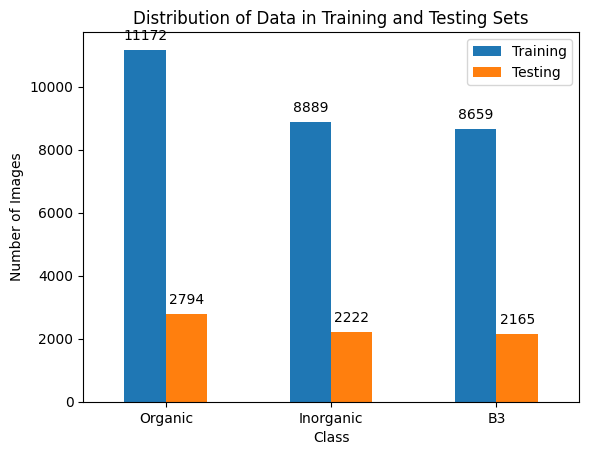

In [66]:
# Count the number of images in each class for the training and testing sets
train_class_counts = train_df['label'].value_counts().sort_index()
test_class_counts = test_df['label'].value_counts().sort_index()

# Create a DataFrame for plotting
class_counts_df = pd.DataFrame({
    'Training': train_class_counts,
    'Testing': test_class_counts
})
class_counts_df.index = ['Organic', 'Inorganic', 'B3']  # Rename the index to class names

# Plotting
ax = class_counts_df.plot(kind='bar')
plt.title('Distribution of Data in Training and Testing Sets')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=0)

# Adding the text annotations on each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [67]:
import random

# Randomly select 15 images from the training set
sample_images = train_df.sample(n=15, random_state=42)

# Plotting
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    # Get the file path and label
    img_path = sample_images.iloc[i]['file_path']
    label = sample_images.iloc[i]['label']
    label_name = 'Organic' if label == 0 else 'Inorganic' if label == 1 else 'B3'

    # Load and display the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [47]:
# Print some sample file paths to verify
print(train_df['file_path'].head())
print(test_df['file_path'].head())


4281     BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
28226    BinBot-20231224T045409Z-001\BinBot\B3 Waste\bu...
7702     BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
21272    BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
29280    BinBot-20231224T045409Z-001\BinBot\B3 Waste\el...
Name: file_path, dtype: object
20817    BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
8966     BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
33062    BinBot-20231224T045409Z-001\BinBot\B3 Waste\pe...
3216     BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
9374     BinBot-20231224T045409Z-001\BinBot\kaggle Orga...
Name: file_path, dtype: object


In [57]:
def preprocess_image(image_path):
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            return np.array(img, dtype=np.float32) / 255.0  # Include rescaling here
    except Exception as e:
        return np.zeros((192, 192, 3), dtype=np.float32)

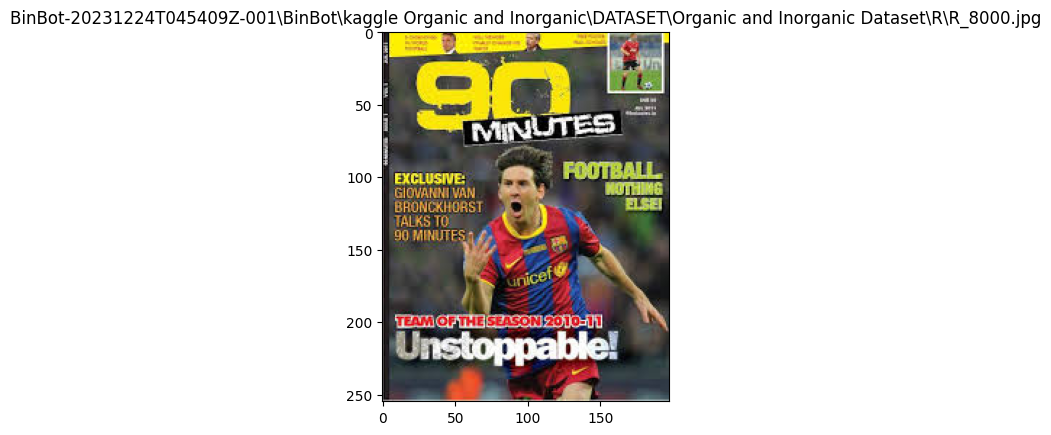

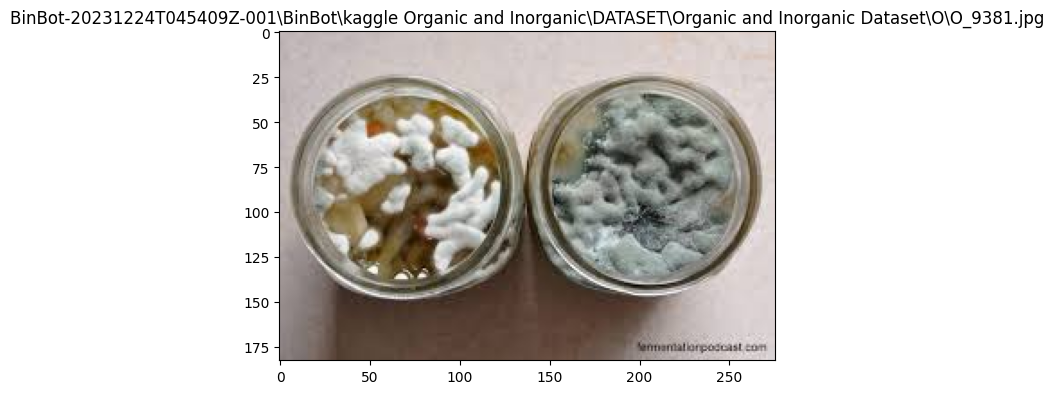

In [68]:
import matplotlib.pyplot as plt

def display_image(image_path):
    processed_image = preprocess_image(image_path)
    plt.imshow(processed_image)
    plt.title(image_path)
    plt.show()

# Display a few preprocessed images
for image_path in train_df['file_path'].sample(5):
    display_image(image_path)


In [58]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image)

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(192, 192),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    color_mode='rgb')

# Test data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(192, 192),
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    color_mode='rgb')

Found 28720 validated image filenames.
Found 7181 validated image filenames.


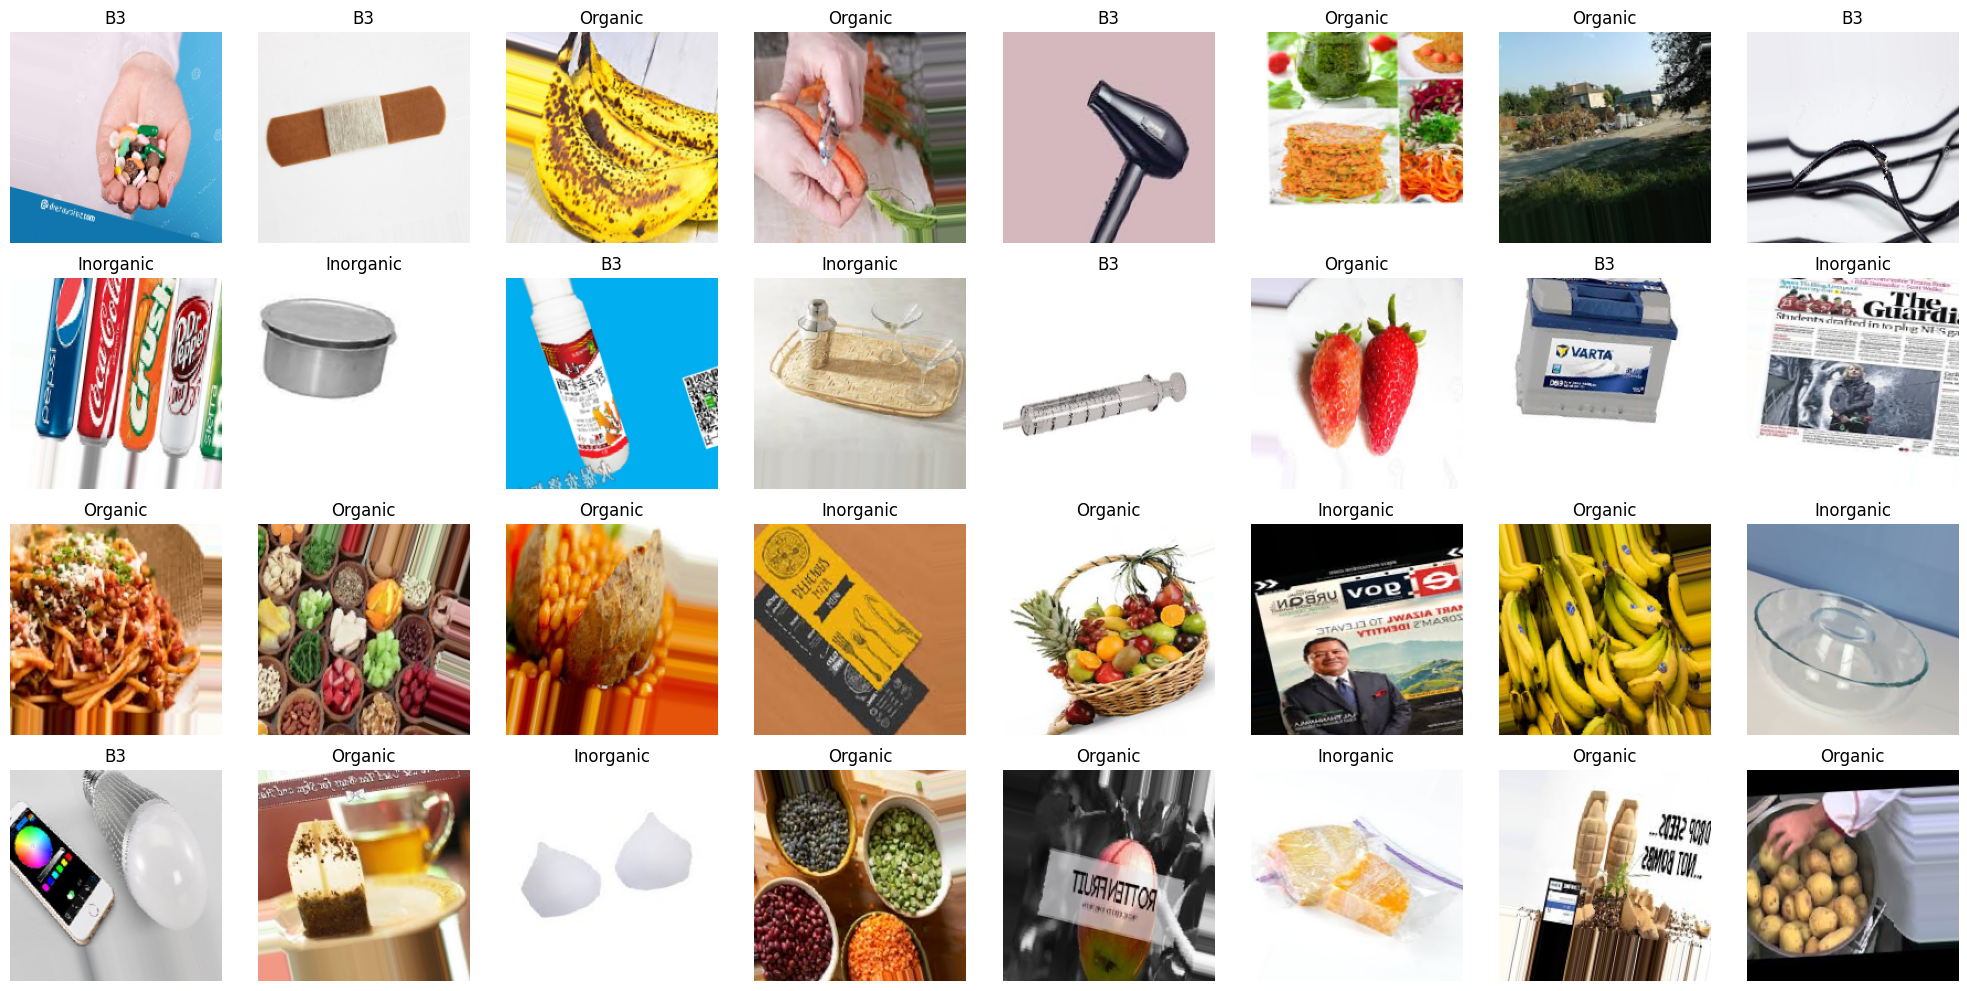

In [11]:
# Fetch the first batch of images and labels
images, labels = next(train_generator)

# Plotting
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(images):
        # Display image
        ax.imshow(images[i])
        # Title with the label
        label = labels[i]
        label_name = 'Organic' if label == 0 else 'Inorganic' if label == 1 else 'B3'
        ax.set_title(label_name)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [50]:
efficientnet_lite_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
base_model = hub.KerasLayer(efficientnet_lite_url, input_shape=(192, 192, 3), trainable=False)

In [51]:
model_input = tf.keras.Input(shape=(192, 192, 3))
x = base_model(model_input)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=model_input, outputs=predictions)

In [52]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [69]:
# Training the model
epochs = 10  # You can adjust the number of epochs
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/10
 23/898 [..............................] - ETA: 11:14 - loss: 1.0941 - accuracy: 0.3899

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 